# Close to Peak COVID

In [1]:
from datetime import date, datetime, timedelta

import itertools


import pandas as pd
import numpy as np

from loguru import logger
import pycountry

from matplotlib.pylab import plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import inset_axes



import seaborn as sns

import plotly.io as pio
import plotly_express as px

import chart_studio.plotly as py
import chart_studio

from IPython.display import clear_output


import sys
import os
sys.path.insert(0, os.path.abspath('../../src/'))
import pipeline

import scipy.stats as ss

import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline

!pwd

/home/barry/projects/covid_projects/predicting_true_cases/notebooks


# Load OWID Datasets

## The Base OWID Dataset

In [2]:
owid = pd.read_pickle('../../generating_covid_datasets/data/base_owid.pkl')
owid.shape, owid['country'].nunique(), owid.date.max()


((42838, 10), 208, Timestamp('2020-09-14 00:00:00'))

## The Infections Dataset

In [3]:
df = pd.read_csv('../data/daily-new-estimated-infections-of-covid-19.csv', parse_dates=['Date']).dropna(subset=['Entity', 'Code', 'Date'])
df.shape

(48049, 9)

In [4]:

df.columns = [
    'country', 'country_code', 'date',
    'new_cases_rolling', 'annotation',
    'new_infections_icl_mean',
    'new_infections_ihme_mean',
    'new_infections_yyg_mean',
    'new_infections_lshtm_median'
]
df.shape

(48049, 9)

### Drop predictions that are lower than action new cases

In [5]:
for prediction_col in df.filter(like='new_infections'):
    
    adj_prediction_col = 'adj_'+prediction_col
    
    df[adj_prediction_col] = np.where(df[prediction_col]>df['new_cases_rolling'], df[prediction_col], np.nan)
    
# Create a mean adjusted new infections col based on the predictions that are valid
df['adj_new_infections_mean'] = df.filter(like='adj_new_infections').mean(axis=1)

df.shape

(48049, 14)

## The Map Data

In [6]:
world = gpd.read_file('../../fatality_analysis/data/ne_50m_admin_0_countries/ne_50m_admin_0_countries.shp')[['ADM0_A3', 'geometry']].to_crs('+proj=robin').rename(columns={'ADM0_A3':'country_code'})

world['coords'] = world['geometry'].apply(lambda x: x.representative_point().coords[0])

world.shape

(241, 3)

## Combine the datasets

In [7]:
world = world.set_index('country_code').join(owid.groupby('country_code').last()).reset_index()
world.shape

(241, 12)

In [8]:
owid_cols = ['continent', 'region', 'new_cases', 'new_deaths', 'new_tests_smoothed', 'population']

df = df.set_index(['country_code', 'date'])\
    .join(owid.set_index(['country_code', 'date'])[owid_cols])\
    .reset_index()

df.shape

(48049, 20)

In [9]:
df['test_positivity'] = df['new_cases_rolling']/df['new_tests_smoothed']

## Calculate the fraction infected

In [10]:
df['frac_cum_infections'] = df.groupby('country')['adj_new_infections_mean'].transform('cumsum')/df['population']

df.shape

(48049, 22)

# Ireland Analysis

In [11]:
start_date = datetime(2020, 3, 15)
ireland = df[df['country']=='Ireland'].set_index('date').loc[start_date:]

ireland.shape, ireland['new_cases_rolling'].iloc[-1], ireland['new_cases_rolling'].max(),ireland['new_cases_rolling'].iloc[-1]/ireland['new_cases_rolling'].max()

((185, 21), 202.57143, 903.28571, 0.22426063841970886)

## Estimated New Daily Infections by Model

[10241.0, 5579.0, 0.01768800507762914, 0.20359970878867747]

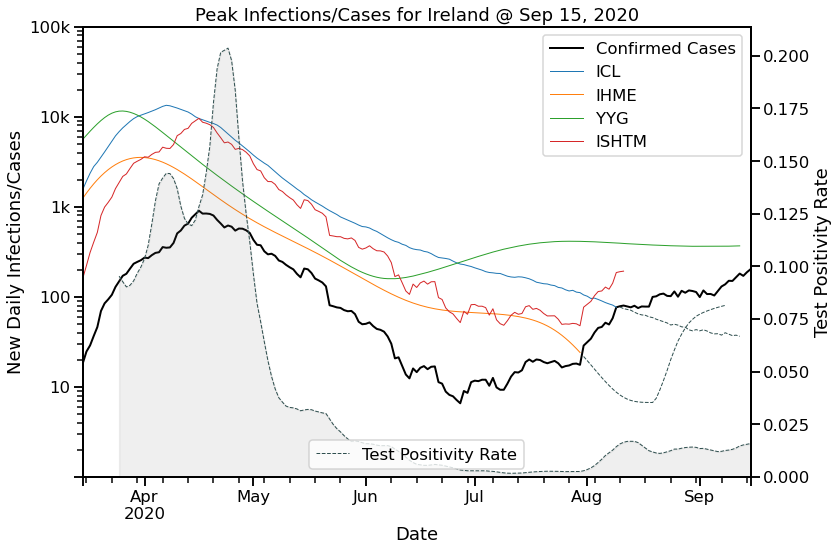

In [12]:
sns.set_context('talk')

fig, ax = plt.subplots(figsize=(12, 8))
bx = ax.twinx()

ireland['new_cases_rolling'].plot(ax=ax, lw=2, c='k')

for infection_model in ireland.filter(regex='^new_infections').columns:
    
    above_cases = ireland[infection_model]>ireland['new_cases_rolling']
    
    l = ireland[above_cases][infection_model].plot(ax=ax, lw=1).get_lines()[-1]

ireland['test_positivity'].rolling('7d').mean().plot(ax=bx, lw=1, ls='--', c='darkslategrey')
bx.fill_between(ireland['test_positivity'].index, 0, ireland['test_positivity'].rolling('7d').mean(), color='dimgrey', alpha=.1)

ax.set_yscale('log')

bx.set_ylim(0)
ax.set_ylim(1, 100000)

ax.set_yticklabels(['', '', '10', '100', '1k', '10k', '100k', '1M'])


ax.legend(['Confirmed Cases', 'ICL', 'IHME', 'YYG', 'ISHTM'], loc='upper right', frameon=False)
bx.legend(['Test Positivity Rate'], loc='lower center', frameon=True)

ax.set_title('Peak Infections/Cases for Ireland @ {}'.format(ireland.index[-1].strftime('%b %d, %Y')))

for infection_model in ireland.filter(regex='^new_infections').columns:
    
    above_cases = ireland[infection_model]>ireland['new_cases_rolling']
    
    ireland[~above_cases][infection_model].plot(ax=ax, lw=1, ls='--', c='darkslategrey')

    

ax.set_xlabel('Date')
ax.set_ylabel('New Daily Infections/Cases')
bx.set_ylabel('Test Positivity Rate')




fig.tight_layout()

[
    ireland['new_tests_smoothed'].dropna().iloc[-1], ireland['new_tests_smoothed'].loc[ireland['new_cases_rolling'].idxmax()],
    ireland['test_positivity'].dropna().iloc[-1], ireland['test_positivity'].rolling('7d').mean().max(),
]

This graph shows the number of confirmed cases per day in Ireland versus the infection predictions produced by each of the 4 models. One unusual feature of these predictions is that sometimes they are lower than the actual number of confirmed cases. For example, here we see that the IHME model's predictions dip below Ireland's confirmed cases at the beginning of August and the ICL model follows suit a few days later. I think this arises when there are periods with very low (possibly 0) deaths. Whatever the explanation, the predictions from these models are clearly incorrect at the moment. 

## Drop predictions < confirmed cases

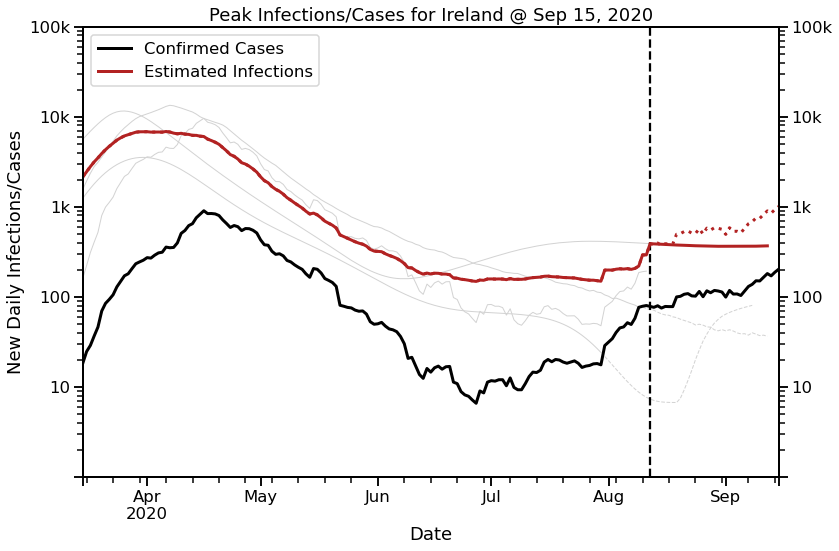

In [13]:

fig, ax = plt.subplots(figsize=(12, 8))
bx = ax.twinx()

for infection_model in ireland.filter(regex='^new_infections').columns:
    
    above_cases = ireland[infection_model]>ireland['new_cases_rolling']
    
    ireland[above_cases][infection_model].plot(ax=ax, lw=1, c='lightgrey')
    ireland[~above_cases][infection_model].plot(ax=ax, lw=1, c='lightgrey', ls='--')
    
ireland['new_cases_rolling'].plot(ax=bx, lw=3, c='k')
ireland['adj_new_infections_mean'].plot(ax=bx, lw=3, c='firebrick')


ax.set_yscale('log')
bx.set_yscale('log')


ax.set_xlabel('Date')
ax.set_ylabel('New Daily Infections/Cases')

ax.set_ylim(1, 100000)
bx.set_ylim(1, 100000)

ax.set_yticklabels(['', '', '10', '100', '1k', '10k', '100k', '1M'])
bx.set_yticklabels(['', '', '10', '100', '1k', '10k', '100k', '1M'])

aug_12 = datetime(2020, 8, 12)
ax.axvline(aug_12, color='k', ls='--')

infection_gap = (ireland['adj_new_infections_mean']/ireland['new_cases_rolling'])

ireland.loc[ireland.loc[:aug_12].index, 'adj_new_infections_mean2'] = ireland['adj_new_infections_mean']
ireland.loc[ireland.loc[aug_12:].index, 'adj_new_infections_mean2'] = ireland['new_cases_rolling'].loc[aug_12:]*infection_gap.loc[:aug_12].iloc[-1]


ireland['adj_new_infections_mean2'].plot(ax=bx, lw=3, c='firebrick', ls=':')

ax.legend().remove()
bx.legend(['Confirmed Cases', 'Estimated Infections'], loc='upper left')

ax.set_title('Peak Infections/Cases for Ireland @ {}'.format(ireland.index[-1].strftime('%b %d, %Y')))



fig.tight_layout()

In this version the estimated infections is based on the average of the infection models during periods when their individual predictions exceed confirmed cases; in other words, if a model predicts fewer infections than there were cases on a particular day, then that model's predictions are not included in the averaging. One implication of this is that the most recent infection estimates (from early August) are based exlusively on the Youyang Gu model. 

It is clear too that the gap between true infections and confirmed cases is narrowing, even though positivity rates have been, at best stable, if not rising in recent days. To compensate for this, in the above, from August 12, the predicted number of new infections are scaled from new cases based on the infection gap from August 12, causing new infections to rise with confirmed cases.

# Current Relative Peaks

In [14]:
ireland['infection_peak'] = ireland['adj_new_infections_mean2'].max()
ireland['case_peak'] = ireland['new_cases_rolling'].max()

ireland['rel_new_infections'] = ireland['adj_new_infections_mean2']/ireland['infection_peak']
ireland['rel_new_cases'] = ireland['new_cases_rolling']/ireland['case_peak']


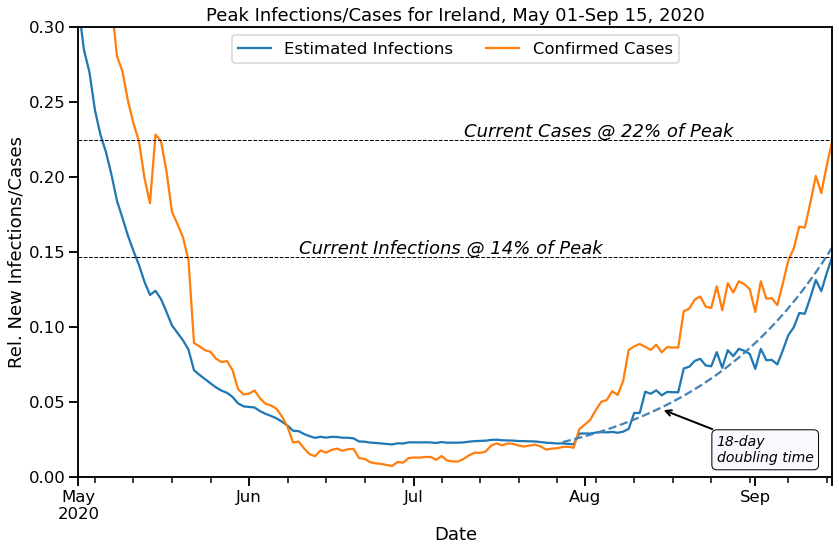

In [16]:
fig, ax = plt.subplots(figsize=(12, 8))

from_date = datetime(2020, 5, 1)

# Plot the cases and infections
ireland.loc[from_date:]['rel_new_infections'].plot(ax=ax)
ireland.loc[from_date:]['rel_new_cases'].plot(ax=ax)


def doubling_time(start, days, dt=1):
    return [start*(2**(day/dt)) for day in range(1, days+1)]

num_days = 50
dt = 18
dt_infections = pd.Series(doubling_time(ireland['rel_new_infections'].iloc[-num_days], num_days, dt), index=ireland['rel_new_infections'].index[-num_days:])
dt_infections.plot(ax=ax, c='steelblue', ls='--')


ax.set_xlabel('Date')
ax.set_ylabel('Rel. New Infections/Cases')

ax.set_ylim(0, .30)

ax.legend(['Estimated Infections', 'Confirmed Cases'], frameon=True, ncol=2, loc='upper center')

current_infections_peak = ireland.loc[from_date:]['rel_new_infections'].dropna().iloc[-1]
current_cases_peak = ireland.loc[from_date:]['rel_new_cases'].dropna().iloc[-1]

ax.axhline(current_infections_peak, c='k', lw=1, ls='--')
ax.axhline(current_cases_peak, c='k', lw=1, ls='--')

ax.text(from_date+timedelta(days=40), current_infections_peak+.0025, 'Current Infections @ {}% of Peak'.format(int(100*current_infections_peak)), style='oblique')
ax.text(from_date+timedelta(days=70), current_cases_peak+.0025, 'Current Cases @ {}% of Peak'.format(int(100*current_cases_peak)), style='oblique')

ax.annotate(
        '{}-day\ndoubling time'.format(dt), 
        xy=(datetime(2020, 8, 15), .045), 
        xytext=(datetime(2020, 8, 25), .01), 
        arrowprops=dict(arrowstyle="->", connectionstyle="arc3", lw=2),
        bbox=dict(facecolor='ghostwhite', edgecolor='black', boxstyle='round,pad=.35', lw=1), 
        fontsize=14, style='oblique', ha='left')


ax.set_title('Peak Infections/Cases for Ireland, {}-{}'.format(from_date.strftime('%b %d'), ireland.index[-1].strftime('%b %d, %Y')))

fig.tight_layout()

In [ ]:
# fig, ax = plt.subplots(figsize=(25, 25))

# def plot_world_map(ax, world, col, xlims=None, ylims=None):
    
#     use_palette = 'coolwarm'
#     norm = matplotlib.colors.Normalize(vmin=world[col].min(), vmax=world[col].max())
#     cmap = matplotlib.cm.get_cmap(use_palette)

#     world.plot(column=col, cmap=use_palette, norm=norm, ax=ax, lw=.5, edgecolor='darkslategrey')

#     ax.tick_params(axis=u'both', which=u'both',length=0)
#     ax.set_xticklabels([])
#     ax.set_yticklabels([])
    
#     if xlims is not None: ax.set_xlim(*xlims)
#     if ylims is not None: ax.set_ylim(*ylims)

    

# plot_world_map(ax, world, 'rel_new_infections')

# fig.tight_layout()